In [14]:
import numpy as np
import torch
from DQN_Agent_lib import *
from RAT_env import *
from RL import *
import matplotlib.pyplot as plt
from collections import Counter
from heuristic import *
from HartRL import *
from evaluate import *

Initialize enviroment

In [3]:
# Parameters for the Multi-RAT Network
area_width = 150
n_aps = 9
n_users = 20
n_steps = 10
rat_env = Multi_RAT_Network(area_width, n_users, n_aps, n_steps, plot=False,train=False)
# Simulation parameters
n_episodes = 100


### Load algorithms

In [4]:
# Load DQN
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))

# Load Heuristic Approach
h_value = 1
p_switch = 0.8
m = 0
h_rewards, h_actions = run_heuristic(rat_env, n_episodes, h_value, p_switch, m)

#Load Hart RL appraoch
p_vectors = run_Hart_RL(rat_env, n_steps, sim_steps=300)

Simulation progress:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\alvar\Documents\TELECO\cuarto\2 º Cuatri\Thesis\DQN_RAT_selection\heuristic.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards_buffer.append(torch.tensor(lr))
Simulation Progress: 100%|██████████| 300/300 [00:21<00:00, 14.20it/s]


Evaluate algorithms and store results

In [5]:
import numpy as np

N_RUNS = 10
all_dqn_results = []
all_heuristic_results = []
all_hart_results = []

# Run DQN policy evaluation 5 times
for seed in range(N_RUNS):
    np.random.seed(seed)
    torch.manual_seed(seed)
    rat_env.reset()
    rewards, actions = evaluate_action_network(rat_env, action_network, n_episodes)
    all_dqn_results.append((rewards, actions))

# Run heuristic evaluation 5 times
for seed in range(N_RUNS):
    np.random.seed(seed)
    torch.manual_seed(seed)
    rat_env.reset()
    h_rewards, h_actions = run_heuristic(rat_env, n_episodes, h_value, p_switch, m)
    all_heuristic_results.append((h_rewards, h_actions))

# Run HART-RL evaluation 5 times
for seed in range(N_RUNS):
    np.random.seed(seed)
    torch.manual_seed(seed)
    rat_env.reset()
    hart_rewards, hart_actions = evaluate_hart_rl(p_vectors, rat_env, n_episodes)
    all_hart_results.append((hart_rewards, hart_actions))


Simulation progress: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


### Plot results for DQN

Plot average_throughput per user and fairness

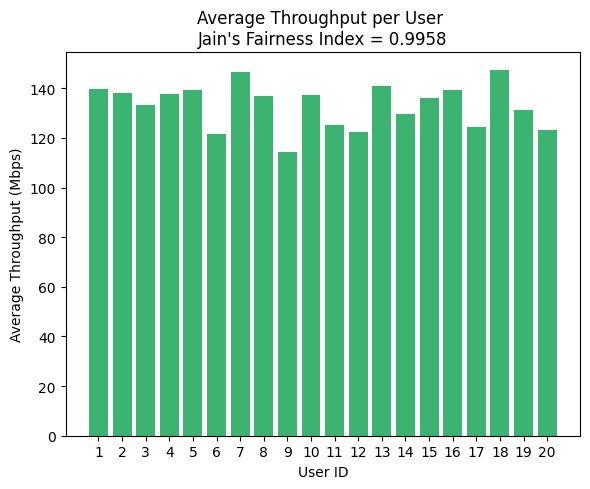

In [ ]:
reward = all_dqn_results[0][0]

throughput_buffer = [
    [reward * rat_env.max_thr for reward in rewards]
    for rewards in rewards
]

# Compute average throughput per user
n_users = len(throughput_buffer[0])
avg_throughput_per_user = [
    np.mean([throughput_buffer[episode][user] for episode in range(len(throughput_buffer))])
    for user in range(n_users)
]

# Compute Jain's fairness index
numerator = (sum(avg_throughput_per_user)) ** 2
denominator = n_users * sum(x ** 2 for x in avg_throughput_per_user)
jain_index = numerator / denominator if denominator != 0 else 0

# Plot average throughput per user
plt.figure(figsize=(6, 5))
plt.bar(range(n_users), avg_throughput_per_user, color='mediumseagreen')
plt.xlabel('User ID')
plt.xticks(ticks=range(n_users), labels=[f'{i+1}' for i in range(n_users)])
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per User \nJain\'s Fairness Index = {jain_index:.4f}')
plt.tight_layout()
plt.show()

### Compare different algorithms results

Average Throughput and Fairness

C:\Users\alvar\AppData\Local\Temp\ipykernel_9276\3855240136.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  throughput = np.array(timestep_rewards) * max_thr


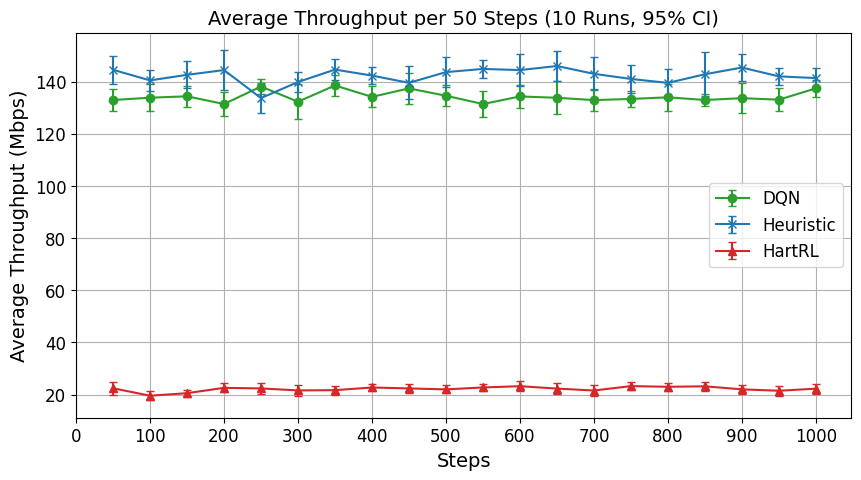

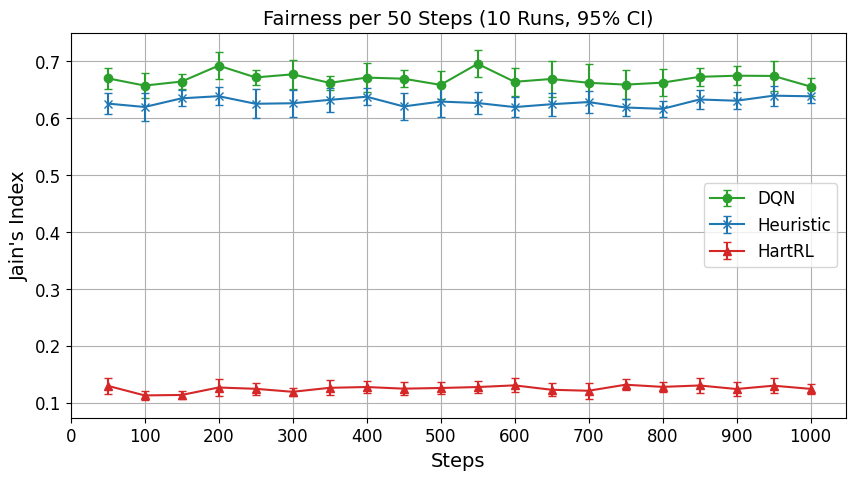

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg_metrics(reward_data, n_steps, k, max_thr):
    avg_throughput = []
    avg_fairness = []
    throughput_accum = []
    fairness_accum = []

    for i, timestep_rewards in enumerate(reward_data):
        throughput = np.array(timestep_rewards) * max_thr
        throughput_accum.extend(throughput)
        numerator = (np.sum(throughput)) ** 2
        denominator = len(throughput) * np.sum(throughput ** 2)
        fairness = numerator / denominator if denominator != 0 else 0
        fairness_accum.append(fairness)
        if (i + 1) % (n_steps * k) == 0:
            avg_throughput.append(np.mean(throughput_accum))
            avg_fairness.append(np.mean(fairness_accum))
            throughput_accum = []
            fairness_accum = []
    
    return avg_throughput, avg_fairness
def compute_avg_and_ci(all_rewards, n_steps, k, max_thr):
    all_throughputs = []
    all_fairnesses = []

    for rewards in all_rewards:
        avg_thr, avg_fair = compute_avg_metrics(rewards, n_steps, k, max_thr)
        all_throughputs.append(avg_thr)
        all_fairnesses.append(avg_fair)

    # Convert to arrays for easy axis operations
    all_throughputs = np.array(all_throughputs)  # Shape: [N_RUNS, len(metric)]
    all_fairnesses = np.array(all_fairnesses)

    # Mean and 95% confidence interval
    mean_thr = np.mean(all_throughputs, axis=0)
    ci_thr = 1.96 * np.std(all_throughputs, axis=0, ddof=1) / np.sqrt(len(all_throughputs))

    mean_fair = np.mean(all_fairnesses, axis=0)
    ci_fair = 1.96 * np.std(all_fairnesses, axis=0, ddof=1) / np.sqrt(len(all_fairnesses))

    return mean_thr, ci_thr, mean_fair, ci_fair

k=5 #Episodes

# Compute averages + CIs
mean_thr_dqn, ci_thr_dqn, mean_fair_dqn, ci_fair_dqn = compute_avg_and_ci([r for r, _ in all_dqn_results], n_steps, k, rat_env.max_thr)
mean_thr_heur, ci_thr_heur, mean_fair_heur, ci_fair_heur = compute_avg_and_ci([r for r, _ in all_heuristic_results], n_steps, k, rat_env.max_thr)
mean_thr_hart, ci_thr_hart, mean_fair_hart, ci_fair_hart = compute_avg_and_ci([r for r, _ in all_hart_results], n_steps, k, rat_env.max_thr)

x_vals = [(i + 1) * k * n_steps for i in range(len(mean_thr_dqn))]

# --- Throughput Plot with CI ---
plt.figure(figsize=(10, 5))
plt.errorbar(x_vals, mean_thr_dqn, yerr=ci_thr_dqn, label='DQN', fmt='-o', color='tab:green', capsize=3)
plt.errorbar(x_vals, mean_thr_heur, yerr=ci_thr_heur, label='Heuristic', fmt='-x', color='tab:blue', capsize=3)
plt.errorbar(x_vals, mean_thr_hart, yerr=ci_thr_hart, label='HartRL', fmt='-^', color='tab:red', capsize=3)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Average Throughput (Mbps)", fontsize=14)
plt.title(f"Average Throughput per {k*n_steps} Steps ({N_RUNS} Runs, 95% CI)", fontsize=14)
plt.xticks(np.arange(0, max(x_vals) + 1, 10*n_steps), fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# --- Fairness Plot with CI ---
plt.figure(figsize=(10, 5))
plt.errorbar(x_vals, mean_fair_dqn, yerr=ci_fair_dqn, label='DQN', fmt='-o', color='tab:green', capsize=3)
plt.errorbar(x_vals, mean_fair_heur, yerr=ci_fair_heur, label='Heuristic', fmt='-x', color='tab:blue', capsize=3)
plt.errorbar(x_vals, mean_fair_hart, yerr=ci_fair_hart, label='HartRL', fmt='-^', color='tab:red', capsize=3)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Jain's Index", fontsize=14)
plt.title(f"Fairness per {k*n_steps} Steps ({N_RUNS} Runs, 95% CI)", fontsize=14)
plt.xticks(np.arange(0, max(x_vals) + 1, 10*n_steps), fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


Congestion analysis: % of users connected to top 4 busy stations

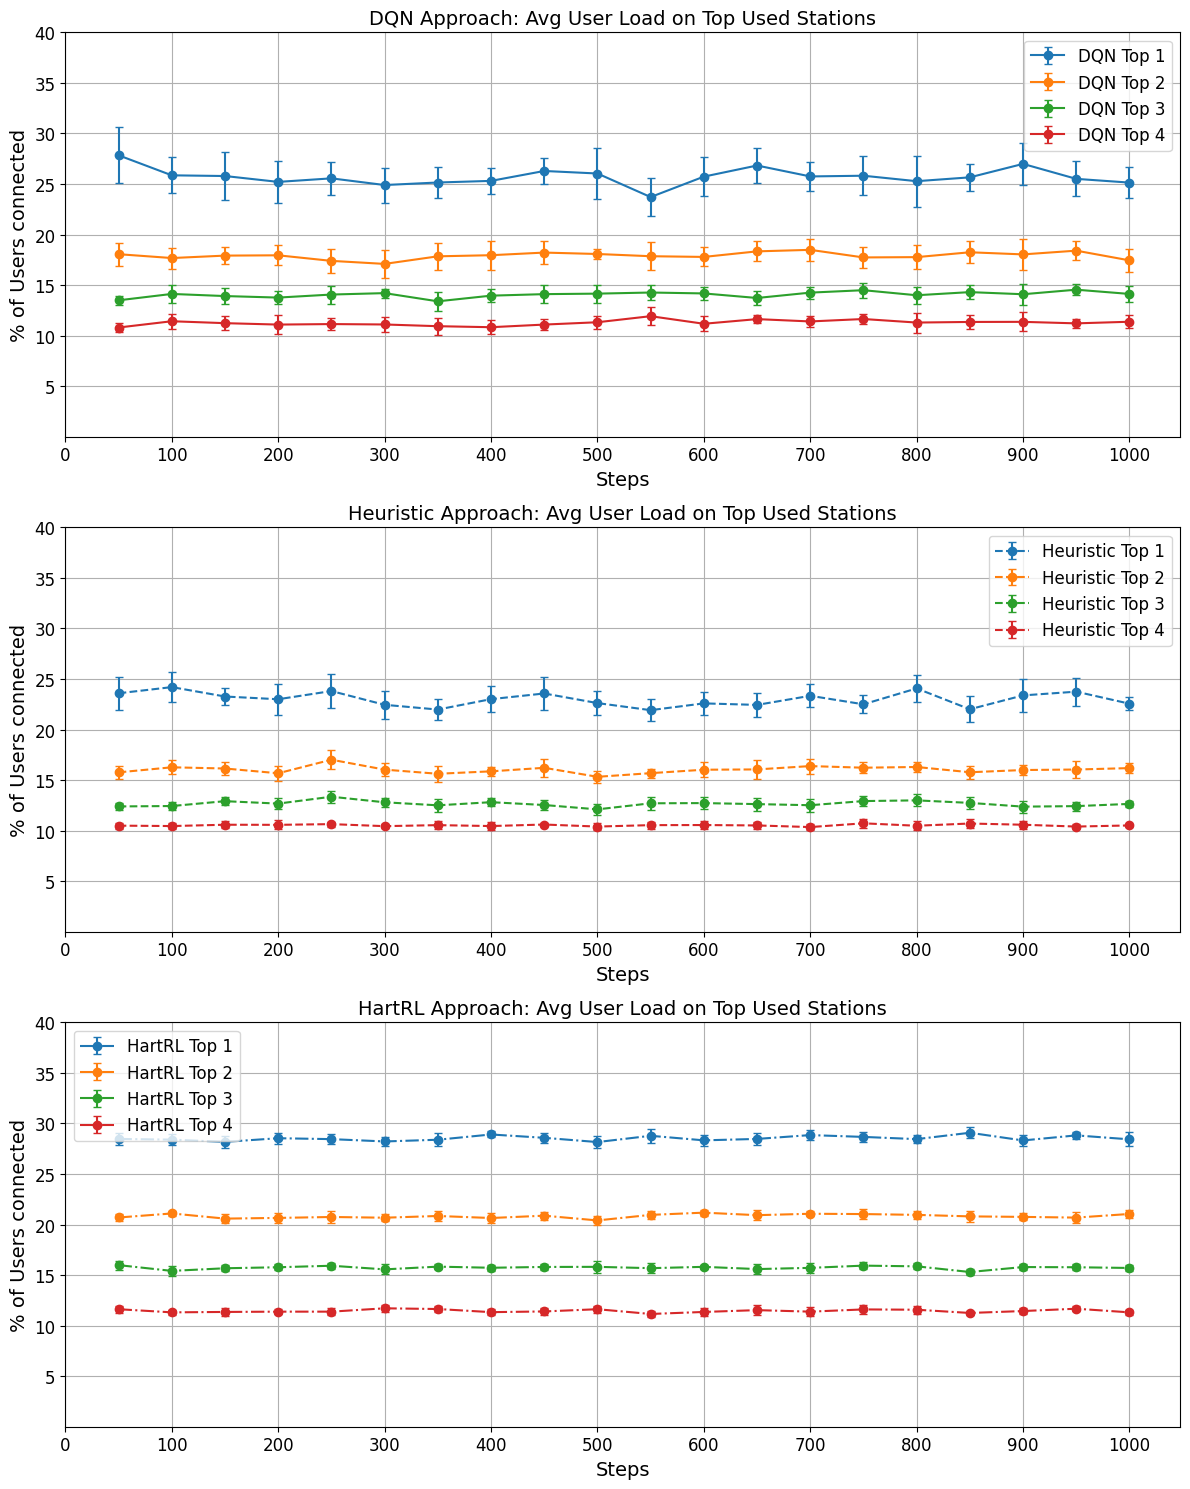

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import sem, t

def plot_station_load_with_ci(all_dqn_actions, all_heur_actions, all_hart_actions, n_steps, max_episodes=None, k=1, top_k=4, confidence=0.95):
    n_runs = len(all_dqn_actions)
    n_users = rat_env.n_users
    n_timesteps = len(all_dqn_actions[0])
    total_episodes = n_timesteps // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)
    grouped_episode_count = n_episodes // k
    x_vals = [(i + 1) * k *n_steps for i in range(grouped_episode_count)]
    colors = plt.cm.tab10.colors

    def compute_avg_and_ci(all_actions):
        all_top_k_runs = []
        for run_actions in all_actions:
            top_k_percentages = [[] for _ in range(top_k)]
            for group in range(grouped_episode_count):
                group_top_k = [[] for _ in range(top_k)]
                for ep in range(group * k, (group + 1) * k):
                    ep_start = ep * n_steps
                    ep_end = (ep + 1) * n_steps
                    for time in range(ep_start, ep_end):
                        station_counts = Counter(a.item() for a in run_actions[time])
                        top_k_counts = station_counts.most_common(top_k)
                        for i in range(top_k):
                            percent = (top_k_counts[i][1] / n_users) * 100 if i < len(top_k_counts) else 0.0
                            group_top_k[i].append(percent)
                for i in range(top_k):
                    top_k_percentages[i].append(np.mean(group_top_k[i]))
            all_top_k_runs.append(top_k_percentages)

        # Convert to np array: shape = [top_k, n_runs, grouped_episode_count]
        all_top_k_runs = np.array(all_top_k_runs).transpose(1, 0, 2)

        means = np.mean(all_top_k_runs, axis=1)
        ci = t.ppf((1 + confidence) / 2, df=n_runs - 1) * sem(all_top_k_runs, axis=1)

        return means, ci

    # Compute for each method
    dqn_means, dqn_ci = compute_avg_and_ci(all_dqn_actions)
    heur_means, heur_ci = compute_avg_and_ci(all_heur_actions)
    hart_means, hart_ci = compute_avg_and_ci(all_hart_actions)

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    def plot_with_ci(ax, means, ci, label_prefix, title, marker, linestyle):
        for i in range(top_k):
            ax.errorbar(
                x_vals, means[i], yerr=ci[i], label=f'{label_prefix} Top {i+1}',
                marker=marker, linestyle=linestyle, color=colors[i % len(colors)], capsize=3
            )
        ax.set_title(title, fontsize = 14)
        ax.set_ylabel('% of Users connected',fontsize = 14)
        ax.set_ylim(0.01, 40)
        ax.grid(True)
        ax.legend(fontsize = 12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xticks(np.arange(0, max(x_vals) + 1, 10*n_steps))


    plot_with_ci(axes[0], dqn_means, dqn_ci, 'DQN', 'DQN Approach: Avg User Load on Top Used Stations', 'o', '-')
    plot_with_ci(axes[1], heur_means, heur_ci, 'Heuristic', 'Heuristic Approach: Avg User Load on Top Used Stations', 'o', '--')
    plot_with_ci(axes[2], hart_means, hart_ci, 'HartRL', 'HartRL Approach: Avg User Load on Top Used Stations', 'o', '-.')

    for ax in axes:
        ax.tick_params(axis='x', labelsize=12)  # Ajusta el tamaño de los xticks
        ax.set_xticks(np.arange(0, max(x_vals) + 1, 10*n_steps))  # Asegura que todos los subplots tengan los mismos xticks
        ax.set_xlabel('Steps', fontsize = 14)
    plt.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()


all_dqn_actions = [actions for _, actions in all_dqn_results]
all_heuristic_actions = [actions for _, actions in all_heuristic_results]
all_hart_actions = [actions for _, actions in all_hart_results]

plot_station_load_with_ci(
    all_dqn_actions, 
    all_heuristic_actions, 
    all_hart_actions, 
    n_steps=n_steps, 
    max_episodes=100, 
    k=5, 
    top_k=4
)


Proportion of users connected to LTE vs Wifi over time

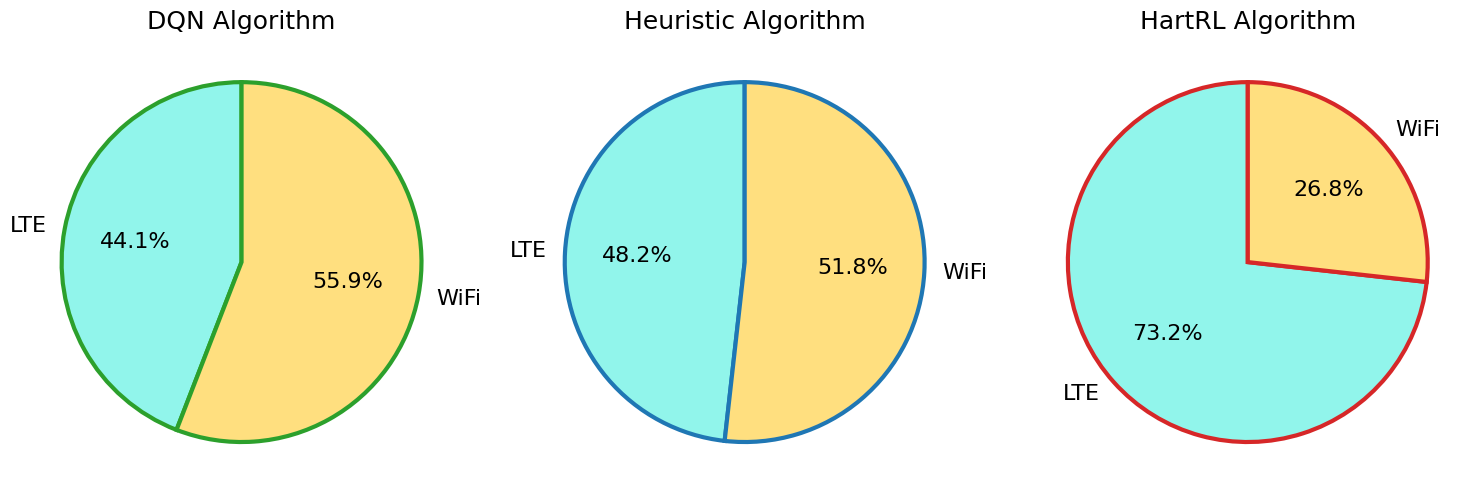

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_rat_piecharts_avg(all_dqn_actions, all_heur_actions, all_hart_actions, rat_env, n_steps, max_episodes=None, k=1):
    n_users = rat_env.n_users
    lte_ids = list(range(rat_env.n_ltesn))
    ap_ids = list(range(rat_env.n_ltesn, rat_env.n_stations))

    def avg_rat_split(all_action_runs):
        lte_shares, ap_shares = [], []
        for actions in all_action_runs:
            n_timesteps = len(actions)
            total_episodes = n_timesteps // n_steps
            n_episodes = min(max_episodes or total_episodes, total_episodes)
            grouped_episode_count = n_episodes // k
            lte_accum, ap_accum = [], []

            for group in range(grouped_episode_count):
                for ep in range(group * k, (group + 1) * k):
                    ep_start = ep * n_steps
                    ep_end = (ep + 1) * n_steps
                    for t in range(ep_start, ep_end):
                        station_counts = Counter(a.item() for a in actions[t])
                        lte_users = sum(station_counts.get(id, 0) for id in lte_ids)
                        ap_users = sum(station_counts.get(id, 0) for id in ap_ids)
                        lte_accum.append((lte_users / n_users) * 100)
                        ap_accum.append((ap_users / n_users) * 100)

            lte_shares.append(np.mean(lte_accum))
            ap_shares.append(np.mean(ap_accum))
        return np.mean(lte_shares), np.mean(ap_shares)

    dqn_lte, dqn_ap = avg_rat_split(all_dqn_actions)
    h_lte, h_ap = avg_rat_split(all_heur_actions)
    hart_lte, hart_ap = avg_rat_split(all_hart_actions)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    labels = ['LTE', 'WiFi']
    colors = ["#91F5EB", "#FFDF7F"]
    textprops = {'fontsize': 16}

    axes[0].pie([dqn_lte, dqn_ap], labels=labels, colors=colors,
                autopct='%1.1f%%', startangle=90, textprops=textprops,
                wedgeprops={'edgecolor': 'tab:green', 'linewidth': 3})
    axes[0].set_title('DQN Algorithm', fontsize=18)

    axes[1].pie([h_lte, h_ap], labels=labels, colors=colors,
                autopct='%1.1f%%', startangle=90, textprops=textprops,
                wedgeprops={'edgecolor': 'tab:blue', 'linewidth': 3})
    axes[1].set_title('Heuristic Algorithm', fontsize=18)

    axes[2].pie([hart_lte, hart_ap], labels=labels, colors=colors,
                autopct='%1.1f%%', startangle=90, textprops=textprops,
                wedgeprops={'edgecolor': 'tab:red', 'linewidth': 3})
    axes[2].set_title('HartRL Algorithm', fontsize=18)

    plt.tight_layout()
    plt.show()

plot_rat_piecharts_avg(all_dqn_actions, all_heuristic_actions, all_hart_actions, rat_env, n_steps, max_episodes=100, k=5)


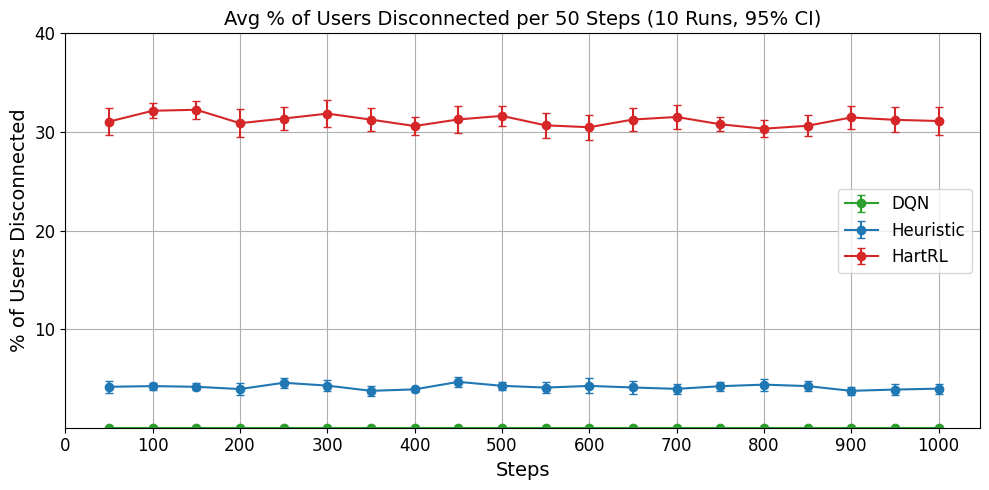

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compute_disconnected_avg_and_ci(all_reward_runs, n_steps, k, confidence=0.95):
    n_users = rat_env.n_users
    grouped_episode_count = len(all_reward_runs[0]) // (n_steps * k)
    all_disconnection_curves = []

    for reward_data in all_reward_runs:
        disconnections = []
        for group in range(grouped_episode_count):
            group_disconnected = []
            for ep in range(group * k, (group + 1) * k):
                start = ep * n_steps
                end = (ep + 1) * n_steps
                for t in range(start, end):
                    rewards_t = reward_data[t]
                    disconnected = sum(1 for r in rewards_t if r < 0)
                    disconnected_percent = (disconnected / n_users) * 100
                    group_disconnected.append(disconnected_percent)
            disconnections.append(np.mean(group_disconnected))
        all_disconnection_curves.append(disconnections)

    # Convert to NumPy array: shape [N_runs, grouped_episode_count]
    all_disconnection_curves = np.array(all_disconnection_curves)

    mean_vals = np.mean(all_disconnection_curves, axis=0)
    std_err = stats.sem(all_disconnection_curves, axis=0)
    ci = std_err * stats.t.ppf((1 + confidence) / 2., len(all_reward_runs) - 1)

    return mean_vals, ci


# Parameters
k = 5
x_vals = [(i + 1) * k * n_steps for i in range(len(all_dqn_results[0][0]) // (n_steps * k))]

# Compute disconnection statistics
dqn_disc_avg, dqn_ci = compute_disconnected_avg_and_ci([r for r, _ in all_dqn_results], n_steps, k)
heur_disc_avg, heur_ci = compute_disconnected_avg_and_ci([r for r, _ in all_heuristic_results], n_steps, k)
hart_disc_avg, hart_ci = compute_disconnected_avg_and_ci([r for r, _ in all_hart_results], n_steps, k)

# --- Plot with CI ---
plt.figure(figsize=(10, 5))
plt.errorbar(x_vals, dqn_disc_avg, yerr=dqn_ci, label='DQN', fmt='-o', color='tab:green', capsize=3)
plt.errorbar(x_vals, heur_disc_avg, yerr=heur_ci, label='Heuristic', fmt='-o', color='tab:blue', capsize=3)
plt.errorbar(x_vals, hart_disc_avg, yerr=hart_ci, label='HartRL', fmt='-o', color='tab:red', capsize=3)

plt.xlabel('Steps', fontsize = 14)
plt.ylabel('% of Users Disconnected', fontsize = 14)
plt.title(f'Avg % of Users Disconnected per {k*n_steps} Steps ({N_RUNS} Runs, 95% CI)', fontsize = 14)
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.arange(0, max(x_vals) + 1, 10*n_steps), fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(0.01, 40)
plt.grid(True)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()


Number of switches

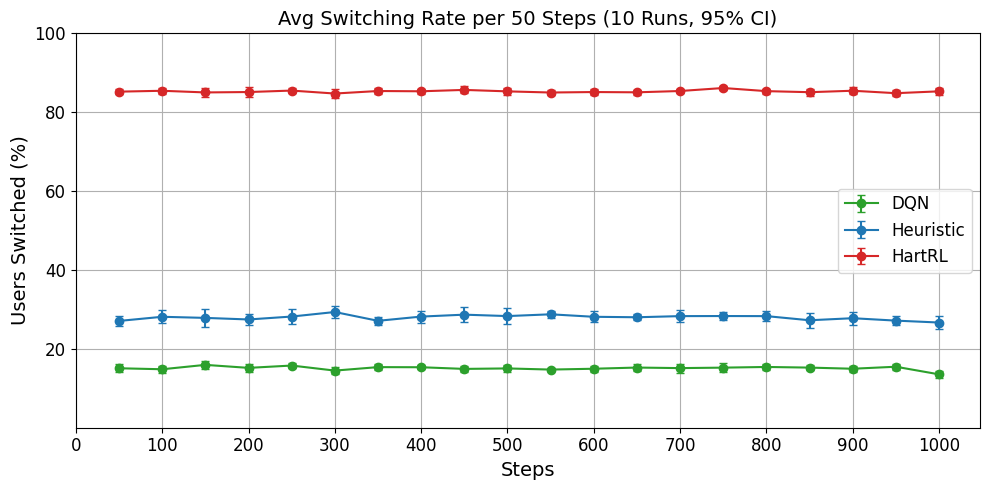

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compute_switching_avg_and_ci(all_action_runs, n_steps, k, confidence=0.95):
    n_users = rat_env.n_users
    grouped_episode_count = len(all_action_runs[0]) // n_steps // k
    all_switch_curves = []

    for action_seq in all_action_runs:
        # Step 1: Compute step-by-step switch % per run
        switch_percentages = []
        user_connections = [a.tolist() for a in action_seq]
        for t in range(1, len(user_connections)):
            prev = user_connections[t - 1]
            curr = user_connections[t]
            switches = sum(1 for i in range(n_users) if prev[i] != curr[i])
            switch_percentages.append((switches / n_users) * 100)

        # Step 2: Aggregate over grouped episodes
        grouped = []
        for group in range(grouped_episode_count):
            group_switch = []
            for ep in range(group * k, (group + 1) * k):
                start = ep * n_steps
                end = (ep + 1) * n_steps
                group_switch.extend(switch_percentages[start:end])
            grouped.append(np.mean(group_switch))
        all_switch_curves.append(grouped)

    all_switch_curves = np.array(all_switch_curves)
    mean_vals = np.mean(all_switch_curves, axis=0)
    std_err = stats.sem(all_switch_curves, axis=0)
    ci = std_err * stats.t.ppf((1 + confidence) / 2., len(all_action_runs) - 1)

    return mean_vals, ci

# Parameters
k = 5
x_vals = [(i + 1) * k *n_steps for i in range(len(all_dqn_results[0][1]) // n_steps // k)]

# Compute switch rates + CI
dqn_mean, dqn_ci = compute_switching_avg_and_ci([a for _, a in all_dqn_results], n_steps, k)
heur_mean, heur_ci = compute_switching_avg_and_ci([a for _, a in all_heuristic_results], n_steps, k)
hart_mean, hart_ci = compute_switching_avg_and_ci([a for _, a in all_hart_results], n_steps, k)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.errorbar(x_vals, dqn_mean, yerr=dqn_ci, label='DQN', fmt='-o', color='tab:green', capsize=3)
plt.errorbar(x_vals, heur_mean, yerr=heur_ci, label='Heuristic', fmt='-o', color='tab:blue', capsize=3)
plt.errorbar(x_vals, hart_mean, yerr=hart_ci, label='HartRL', fmt='-o', color='tab:red', capsize=3)

plt.xlabel("Steps", fontsize = 14)
plt.ylabel("Users Switched (%)", fontsize = 14)
plt.title(f"Avg Switching Rate per {k*n_steps} Steps ({N_RUNS} Runs, 95% CI)",fontsize = 14)
plt.ylim(0.1, 100)
plt.xticks(np.arange(0, max(x_vals) + 1, 10*n_steps), fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()


Number of stations unused

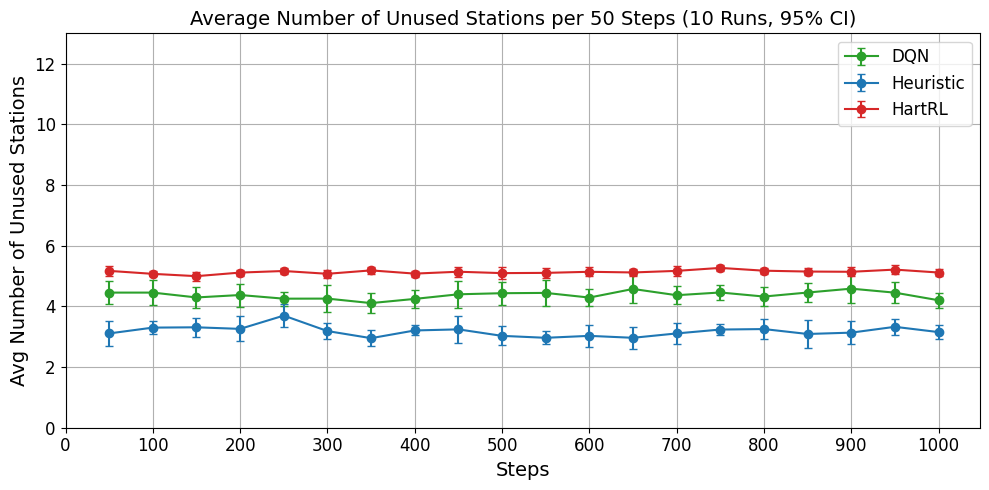

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy import stats

def compute_unused_avg_and_ci(all_action_runs, n_steps, k, n_stations):
    grouped_episode_count = len(all_action_runs[0]) // n_steps // k
    all_unused_stats = []

    for action_seq in all_action_runs:
        unused_counts_per_group = []
        for group in range(grouped_episode_count):
            unused_counts = []
            for ep in range(group * k, (group + 1) * k):
                ep_start = ep * n_steps
                ep_end = (ep + 1) * n_steps
                for t in range(ep_start, ep_end):
                    station_counts = Counter(a.item() for a in action_seq[t])
                    unused = sum(1 for st_id in range(n_stations) if station_counts.get(st_id, 0) == 0)
                    unused_counts.append(unused)
            unused_counts_per_group.append(np.mean(unused_counts))
        all_unused_stats.append(unused_counts_per_group)

    all_unused_stats = np.array(all_unused_stats)
    mean_vals = np.mean(all_unused_stats, axis=0)
    std_err = stats.sem(all_unused_stats, axis=0)
    ci = std_err * stats.t.ppf((1 + 0.95) / 2., len(all_action_runs) - 1)

    return mean_vals, ci

# --- Params ---
k = 5
n_stations = rat_env.n_stations
grouped_episode_count = len(all_dqn_results[0][1]) // n_steps // k
x_vals = [(i + 1) * k*n_steps for i in range(grouped_episode_count)]

# Compute averages and CIs
dqn_mean, dqn_ci = compute_unused_avg_and_ci([a for _, a in all_dqn_results], n_steps, k, n_stations)
heur_mean, heur_ci = compute_unused_avg_and_ci([a for _, a in all_heuristic_results], n_steps, k, n_stations)
hart_mean, hart_ci = compute_unused_avg_and_ci([a for _, a in all_hart_results], n_steps, k, n_stations)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.errorbar(x_vals, dqn_mean, yerr=dqn_ci, label='DQN', fmt='-o', color='tab:green', capsize=3)
plt.errorbar(x_vals, heur_mean, yerr=heur_ci, label='Heuristic', fmt='-o', color='tab:blue', capsize=3)
plt.errorbar(x_vals, hart_mean, yerr=hart_ci, label='HartRL', fmt='-o', color='tab:red', capsize=3)

plt.xlabel('Steps',fontsize = 14)
plt.ylabel('Avg Number of Unused Stations',fontsize = 14)
plt.title(f'Average Number of Unused Stations per {k*n_steps} Steps ({N_RUNS} Runs, 95% CI)',fontsize = 14)
plt.grid(True)
plt.ylim(0, n_stations)
plt.xticks(np.arange(0, max(x_vals) + 1, 10*n_steps), fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()
